# 01A — Split estratificado + balanceo offline + expansión de cámaras (Udacity)

Este notebook extiende 01: además de QC+split, expande cámaras left/right (corrigiendo steering ±shift) y balancea train por bins de steering (oversampling):

- Limpia y normaliza rutas (`IMG/...`).
- (Opcional) Expande cámaras `left/right` reubicándolas en `center` y corrige `steering` ±shift.
- Split estratificado por bins de `steering` → `train/val/test`.
- Oversampling por bins en `train` → `train_balanced.csv`.
- Escribe `tasks.json` y `tasks_balanced.json` para consumo en 03_TRAIN_EVAL.

__Salida clave__: tasks_balanced.json (apunta a train_balanced.csv) para usar en entrenamientos con datos balanceados.

__Cómo encaja en el TFM__: reduce el sesgo hacia “recta” y genera un conjunto de entrenamiento más equilibrado, útil para comparar métodos continual en condiciones más justas.

__Imports, paths y configuración__

Preparamos imports y definimos la __configuración__ de la preparación con expansión y balanceo.

In [1]:
# Raíz y config
from pathlib import Path
import sys, json
import pandas as pd

ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.prep.data_prep import (
    PrepConfig,
    run_prep,
    verify_processed_splits,
    load_raw_log,
    expand_cameras_into_center,
    stratified_split,
    make_balanced_by_bins,
)

RAW  = ROOT / "data" / "raw" / "udacity"
PROC = ROOT / "data" / "processed"

RUNS = ["circuito1", "circuito2"]
CFG = PrepConfig(
    root=ROOT,
    runs=RUNS,
    use_left_right=True,   # <- activamos expansión left/right
    steer_shift=0.2,       # corrección de steering ±shift
    bins=21,
    train=0.70,
    val=0.15,
    seed=42,
    target_per_bin="auto", # <- activamos balanceo offline
    cap_per_bin=12000,
)
CFG


PrepConfig(root=PosixPath('/home/cesar/proyectos/TFM_SNN'), runs=['circuito1', 'circuito2'], use_left_right=True, steer_shift=0.2, bins=21, train=0.7, val=0.15, seed=42, target_per_bin='auto', cap_per_bin=12000)

__Modo A (recomendado): ejecutar todo con run_prep__

Una sola llamada ejecuta QC, split, expansión y balanceo. Debe generar `train_balanced.csv` por run y `tasks_balanced.json`.

In [2]:
manifest = run_prep(CFG)
print("OK:", PROC/"prep_manifest.json")
verify_processed_splits(PROC, RUNS)

tb = manifest["outputs"]["tasks_balanced_json"]
print("tasks_balanced.json:", tb)


OK: /home/cesar/proyectos/TFM_SNN/data/processed/prep_manifest.json
tasks_balanced.json: /home/cesar/proyectos/TFM_SNN/data/processed/tasks_balanced.json


__Modo B (opcional): paso a paso__

Usa helpers concretos para mostrar/depurar cada fase. __Está desactivado por defecto__ (quítale los comentarios si lo necesitas).

In [3]:
# %% OPCIONAL: activar para ver el flujo paso a paso
# manif, manif_bal = [], []
# for run in RUNS:
#     base = RAW / run
#     csv  = base / "driving_log.csv"
#     if not csv.exists():
#         raise FileNotFoundError(f"Falta {csv}")
#
#     # 1) Carga y limpieza
#     df = load_raw_log(base)
#
#     # 2) Expansión (si está configurada)
#     if CFG.use_left_right:
#         df = expand_cameras_into_center(df, CFG.steer_shift)
#
#     # 3) Guardado canonical
#     out = PROC / run
#     out.mkdir(parents=True, exist_ok=True)
#     df.to_csv(out / "canonical.csv", index=False)
#
#     # 4) Split estratificado
#     tr, va, te = stratified_split(
#         df, bins=CFG.bins, train=CFG.train, val=CFG.val, seed=CFG.seed
#     )
#     tr.to_csv(out / "train.csv", index=False)
#     va.to_csv(out / "val.csv",   index=False)
#     te.to_csv(out / "test.csv",  index=False)
#
#     # 5) Balanceo offline
#     trb = make_balanced_by_bins(
#         tr, bins=CFG.bins, target_per_bin=CFG.target_per_bin,
#         cap_per_bin=CFG.cap_per_bin, seed=CFG.seed,
#     )
#     trb.to_csv(out / "train_balanced.csv", index=False)
#
#     # 6) Manifest para tasks.json / tasks_balanced.json
#     manif.append({
#         "run": run,
#         "paths": {
#             "train": str(out/"train.csv"),
#             "val":   str(out/"val.csv"),
#             "test":  str(out/"test.csv"),
#         },
#     })
#     manif_bal.append({
#         "run": run,
#         "paths": {
#             "train": str(out/"train_balanced.csv"),
#             "val":   str(out/"val.csv"),
#             "test":  str(out/"test.csv"),
#         },
#     })
#
# print("OK: splits y balanced generados (modo paso a paso).")


__Histogramas de steering__

Diagnóstico visual del __balanceo__: comparamos histograma de `train.csv` vs `train_balanced.csv` por run.

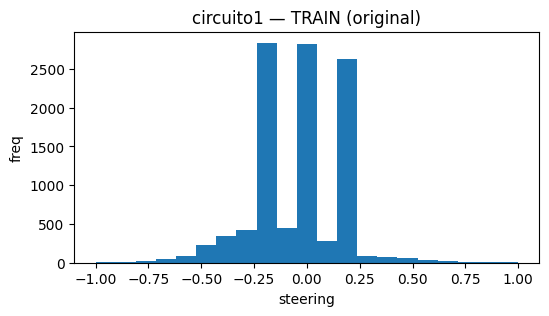

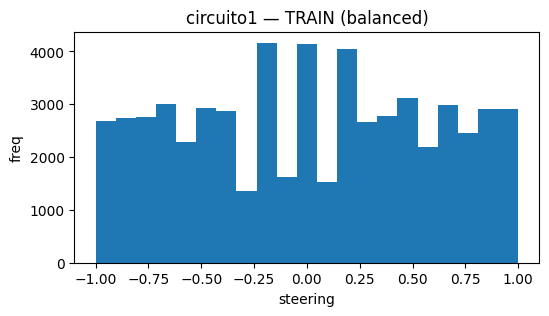

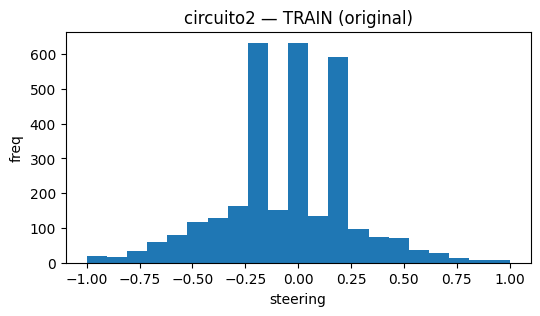

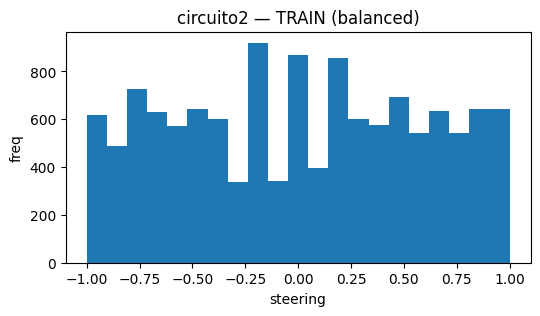

In [4]:
import matplotlib.pyplot as plt, numpy as np, pandas as pd

def plot_hist(csv_path, title):
    df = pd.read_csv(csv_path)
    s = df["steering"].astype(float).clip(-1,1)
    plt.figure(figsize=(6,3))
    plt.hist(s, bins=21)
    plt.title(title); plt.xlabel("steering"); plt.ylabel("freq")
    plt.show()

for run in RUNS:
    base = PROC/run
    plot_hist(base/"train.csv",          f"{run} — TRAIN (original)")
    if (base/"train_balanced.csv").exists():
        plot_hist(base/"train_balanced.csv", f"{run} — TRAIN (balanced)")


**Listo.** Ya puedes ir a `03_TRAIN_EVAL.ipynb` y activar `USE_OFFLINE_BALANCED = True`
para consumir `tasks_balanced.json` (o dejarlo en `False` si quieres usar `tasks.json`).
